## 규제 선형 모델 실습: 보스톤 주택가격 예측

### 모듈 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (mean_squared_error, 
                            mean_absolute_error, 
                            mean_squared_log_error,
                            r2_score)

In [3]:
boston = pd.read_csv('boston.csv')
df = boston.copy()
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


### 데이터 준비

In [4]:
def desc_stats(df):
    desc_df = df.describe(df).T
    desc_df['skew'] = [df[ftr].skew() for ftr in df.columns]

In [5]:
def desc_stats(df):
    desc_df = df.describe(df).T
    desc_df['skew'] = df.skew().values
    desc_df['kurt'] = df.kurtosis.values
    return desc_df

In [6]:
df.skew()

CRIM       5.223149
ZN         2.225666
INDUS      0.295022
CHAS       3.405904
NOX        0.729308
RM         0.403612
AGE       -0.598963
DIS        1.011781
RAD        1.004815
TAX        0.669956
PTRATIO   -0.802325
B         -2.890374
LSTAT      0.906460
price      1.108098
dtype: float64

### 일반 선형 모델 : LinearRegression()

In [7]:
def corr_heatmap(df):
    corr_df = df.corr()
    cmap = sns.diverging_palette(240,10, n=9, as_cmap=True)
    mask = np.zeros_like(corr_df, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(12,12))
    sns.heatmap(corr_df, annot=True, fmt='.3f', annot_kws={'size' : 8}, mask=mask, cmap=cmap,
    linewidths=0.5)
    plt.show()
    return corr_df

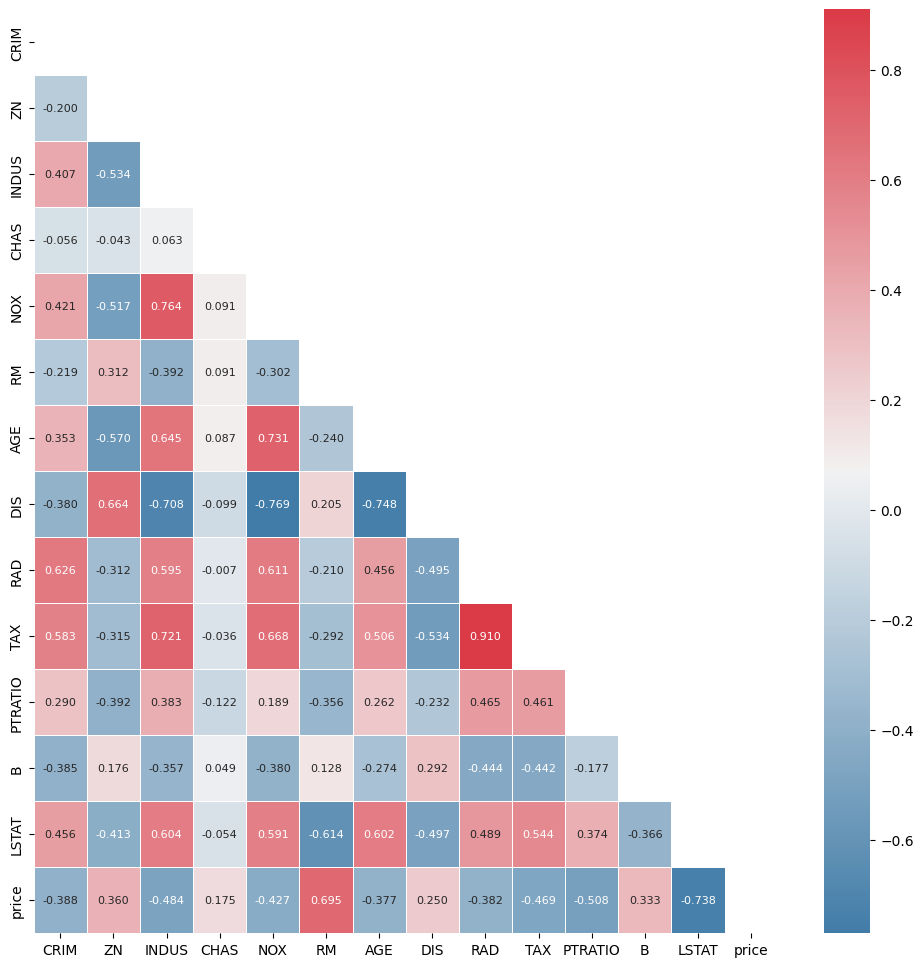

In [8]:
corr_df = corr_heatmap(df)

In [9]:
from scipy import stats

def corr_test(df, dep_varname):
    corrs=[]
    colnames = df.columns
    for col in colnames:
        stat, p = stats.pearsonr(df[dep_varname], df[col])
        print(f'{dep_varname} & {col} \t Pearson Correlation: {stat:.3f}, p: {p:e}')
        print(f'{"상관관계가 있음" if p<0.05 else "무상관" }')
        corrs.append(np.round(stat, 5))

    corr_df = pd.DataFrame(corrs, index=colnames, columns=[f'Corr. with {dep_varname}'])
    return corr_df

In [10]:
corr_test(df,'price')

price & CRIM 	 Pearson Correlation: -0.388, p: 1.173987e-19
상관관계가 있음
price & ZN 	 Pearson Correlation: 0.360, p: 5.713584e-17
상관관계가 있음
price & INDUS 	 Pearson Correlation: -0.484, p: 4.900260e-31
상관관계가 있음
price & CHAS 	 Pearson Correlation: 0.175, p: 7.390623e-05
상관관계가 있음
price & NOX 	 Pearson Correlation: -0.427, p: 7.065042e-24
상관관계가 있음
price & RM 	 Pearson Correlation: 0.695, p: 2.487229e-74
상관관계가 있음
price & AGE 	 Pearson Correlation: -0.377, p: 1.569982e-18
상관관계가 있음
price & DIS 	 Pearson Correlation: 0.250, p: 1.206612e-08
상관관계가 있음
price & RAD 	 Pearson Correlation: -0.382, p: 5.465933e-19
상관관계가 있음
price & TAX 	 Pearson Correlation: -0.469, p: 5.637734e-29
상관관계가 있음
price & PTRATIO 	 Pearson Correlation: -0.508, p: 1.609509e-34
상관관계가 있음
price & B 	 Pearson Correlation: 0.333, p: 1.318113e-14
상관관계가 있음
price & LSTAT 	 Pearson Correlation: -0.738, p: 5.081103e-88
상관관계가 있음
price & price 	 Pearson Correlation: 1.000, p: 0.000000e+00
상관관계가 있음


,Corr. with price
CRIM,-0.38830
ZN,0.36045
INDUS,-0.48373
CHAS,0.17526
NOX,-0.42732
RM,0.69536
AGE,-0.37695
DIS,0.24993
RAD,-0.38163
TAX,-0.46854


In [11]:
price_corr = corr_test(df, 'price')

price & CRIM 	 Pearson Correlation: -0.388, p: 1.173987e-19
상관관계가 있음
price & ZN 	 Pearson Correlation: 0.360, p: 5.713584e-17
상관관계가 있음
price & INDUS 	 Pearson Correlation: -0.484, p: 4.900260e-31
상관관계가 있음
price & CHAS 	 Pearson Correlation: 0.175, p: 7.390623e-05
상관관계가 있음
price & NOX 	 Pearson Correlation: -0.427, p: 7.065042e-24
상관관계가 있음
price & RM 	 Pearson Correlation: 0.695, p: 2.487229e-74
상관관계가 있음
price & AGE 	 Pearson Correlation: -0.377, p: 1.569982e-18
상관관계가 있음
price & DIS 	 Pearson Correlation: 0.250, p: 1.206612e-08
상관관계가 있음
price & RAD 	 Pearson Correlation: -0.382, p: 5.465933e-19
상관관계가 있음
price & TAX 	 Pearson Correlation: -0.469, p: 5.637734e-29
상관관계가 있음
price & PTRATIO 	 Pearson Correlation: -0.508, p: 1.609509e-34
상관관계가 있음
price & B 	 Pearson Correlation: 0.333, p: 1.318113e-14
상관관계가 있음
price & LSTAT 	 Pearson Correlation: -0.738, p: 5.081103e-88
상관관계가 있음
price & price 	 Pearson Correlation: 1.000, p: 0.000000e+00
상관관계가 있음


#### Linear Regression의 교차검증

In [12]:
price_corr.sort_values('Corr. with price', ascending=False)

,Corr. with price
price,1.00000
RM,0.69536
ZN,0.36045
B,0.33346
DIS,0.24993
CHAS,0.17526
AGE,-0.37695
RAD,-0.38163
CRIM,-0.38830
NOX,-0.42732


In [13]:
sel_ftrs = ['CHAS','RAD']
def frequency(df, ftrnames=None):
    if ftrnames is None:
        sel_ftrs = df.select_dtypes(include='int64').columns
    else:
        sel_ftrs = ftrnames
        # sel_rs = ['CHAS','RAD']
    for ftr in sel_ftrs:
        print(df[ftr].value_counts().sort_index())
        print()

In [14]:
frequency(df, ftrnames=sel_ftrs)

CHAS
0    471
1     35
Name: count, dtype: int64

RAD
1      20
2      24
3      38
4     110
5     115
6      26
7      17
8      24
24    132
Name: count, dtype: int64



In [15]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'price'],
      dtype='object')

In [16]:
price_corr.columns=['corr']
price_corr[np.abs(price_corr['corr']) > 0.4].index
# sel_ftrs=[]

Index(['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT', 'price'], dtype='object')

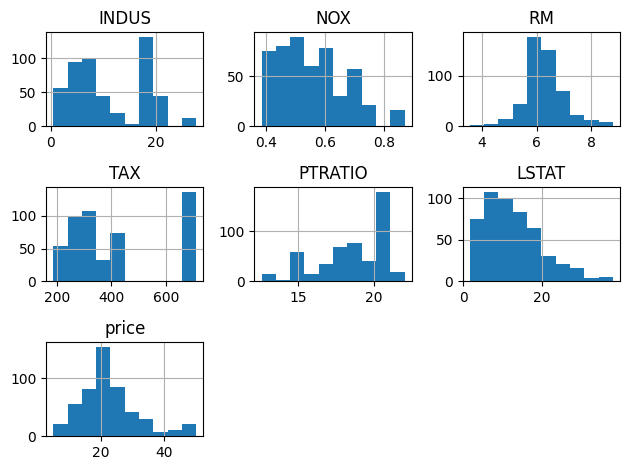

In [17]:
sel_ftrs = price_corr[np.abs(price_corr['corr']) > 0.4].index
df_sel = df[sel_ftrs]
df_sel.hist()
plt.tight_layout()
plt.show()

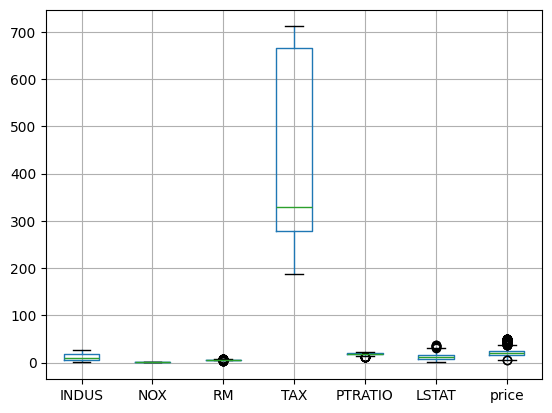

In [18]:
df_sel.boxplot()
plt.show()

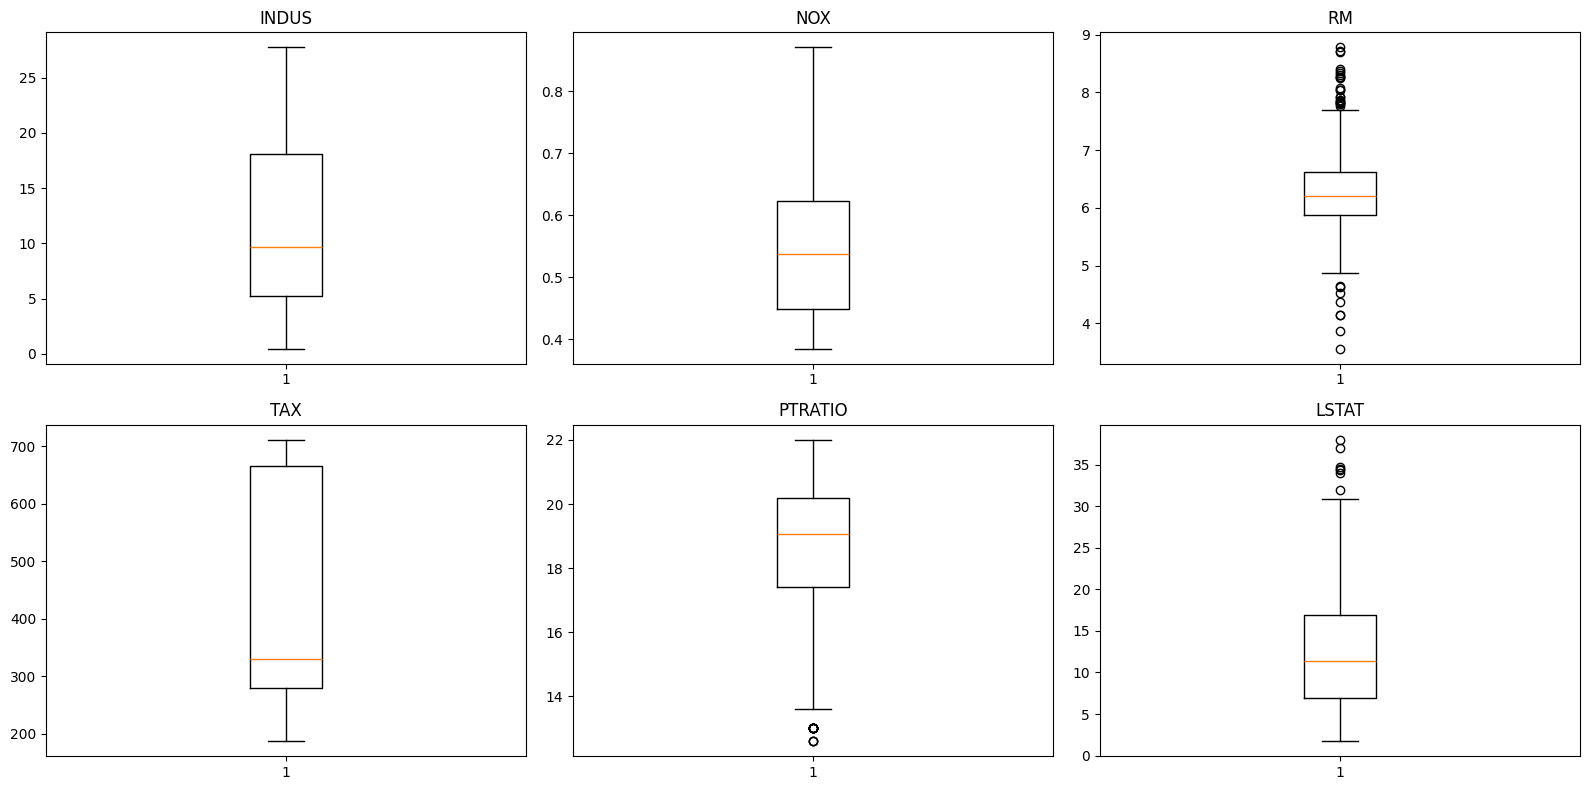

In [19]:
import matplotlib.pyplot as plt

ftr_names = ['INDUS','NOX','RM','TAX','PTRATIO','LSTAT']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
axs = axs.flatten()

for i, ftr in enumerate(ftr_names):
    ax = axs[i]
    ax.boxplot(df_sel[ftr])
    ax.set_title(ftr)

plt.tight_layout()
plt.show()


In [20]:
X= df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020158011)

In [21]:
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def print_eval_regr_scores(y,pred, is_log=False):
    rmse_val = rmse(y, pred)
    mae = mean_absolute_error(y, pred) 
    r2 = r2_score(y, pred)
    if is_log:
        rmsle = mean_squared_log_error(y, pred)
        print(f'RMSE:{rmse_val:.3f}, MAE:{mae:.3f}, RMSLE:{rmsle:.3f}, R2{r2:.3f}')
    else:
        print(f'RMSE:{rmse_val:.3f}, MAE:{mae:.3f},  R2{r2:.3f}')

def get_model_fit_predict(model, X_train, X_test, y_train, y_test, is_log= False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if is_log:
        y_test = np.expm1(y_test)
        y_pred = np.expm1(y_pred)
        text='log변환'
    else:
        text=''
    print(f'{model}, {text}')
    print_eval_regr_scores(y_test, y_pred, is_log=is_log)
    return model
def reg_coeff_plot(model,ftr_names):
    coef = pd.DataFrame(data=np.round(model.coef_, 5),
                        index=ftr_names, columns=['Coef'])
    coef_s = coef.sort_values(by='Coef', ascending=False)
    sns.barplot(x=coef_s['Coef'], y=coef_s.index)
    plt.xlabel('coefficient')
    plt.ylabel('features')
    plt.show()
    print(f'회귀계수\n{coef}')


def get_residual(y_test, y_pred, top_n=10, sort= False):
    df = pd.DataFrame(y_test.values, columns=['Real_y'])
    df['Pred_y'] = np.round(y_pred)
    df['abs(Residual)'] = np.abs(df['Real_y'] - df['Pred_y'])
    if sort:
        print('Sorted')
        df = df.sort_values(by = 'abs(Residual)', ascending=False)
    return df[:top_n]

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print_eval_regr_scores(y_test, y_pred)

RMSE:5.102, MAE:3.545,  R20.760


In [23]:
lr = get_model_fit_predict(lr, X_train, X_test, y_train, y_test)

LinearRegression(), 
RMSE:5.102, MAE:3.545,  R20.760


In [24]:
lr.coef_

array([-1.27863408e-01,  4.48779513e-02,  2.75762397e-02,  2.15962820e+00,
       -1.45790075e+01,  3.72799892e+00,  7.70681778e-03, -1.35748770e+00,
        2.83480341e-01, -1.15863425e-02, -8.97748211e-01,  1.36067255e-02,
       -5.59211686e-01])

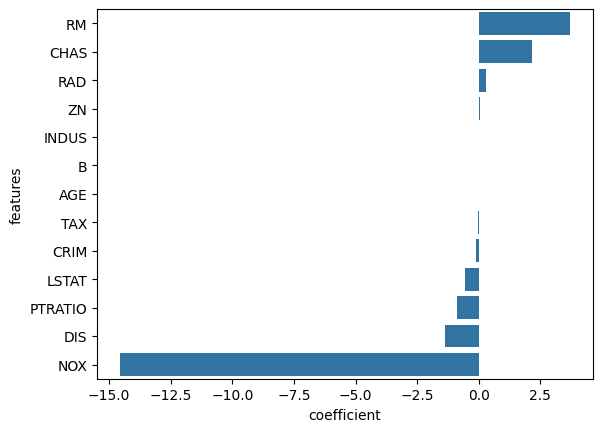

회귀계수
             Coef
CRIM     -0.12786
ZN        0.04488
INDUS     0.02758
CHAS      2.15963
NOX     -14.57901
RM        3.72800
AGE       0.00771
DIS      -1.35749
RAD       0.28348
TAX      -0.01159
PTRATIO  -0.89775
B         0.01361
LSTAT    -0.55921


In [25]:
reg_coeff_plot(lr, X.columns)

## 1. 릿지 회귀모델

#### 릿지 회귀 모델 정의

In [26]:
lr2 = LinearRegression()
scores = cross_val_score(lr2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmses = np.sqrt(scores*(-1))
avg_rmse = np.mean(rmses)
print(f'Negative MSE:{np.round(scores,3)}')
print(f'RMSEs: {np.round(rmses)}\nAverage RMSE: {avg_rmse:.4f}')

Negative MSE:[-17.115 -17.496 -19.325 -31.574 -31.427]
RMSEs: [4. 4. 4. 6. 6.]
Average RMSE: 4.7882


In [27]:
ridge = Ridge(alpha=10)
ridge = get_model_fit_predict(ridge, X_train, X_test, y_train, y_test)

Ridge(alpha=10), 
RMSE:5.317, MAE:3.651,  R20.740


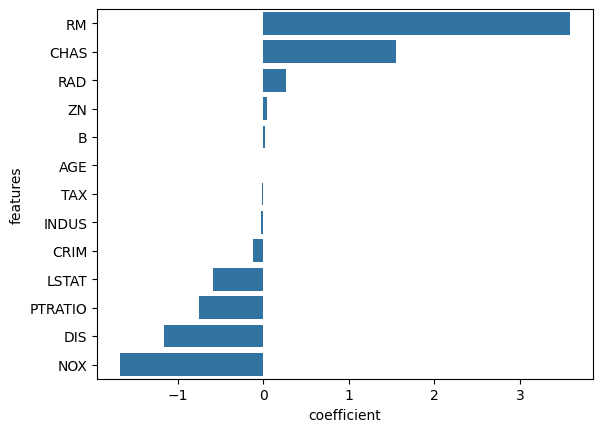

회귀계수
            Coef
CRIM    -0.12465
ZN       0.04685
INDUS   -0.02882
CHAS     1.54560
NOX     -1.68310
RM       3.59058
AGE     -0.00128
DIS     -1.15839
RAD      0.26751
TAX     -0.01320
PTRATIO -0.75993
B        0.01480
LSTAT   -0.59173


In [28]:
ridge_coefs = reg_coeff_plot(ridge, X.columns)

#### 교차검증으로 모델 평가
cross_val_score() 사용

In [29]:
def reg_cv_modeling(model, X, y, cv=5, scoring='neg_mean_squared_error'):
    scores = cross_val_score(ridge2, X_train, y_train, cv=5, scoring=scoring)
    rmses = np.sqrt(scores*(-1))
    avg_rmse = np.mean(rmses)
    print(f'{model}:{cv}-fold CV')
    print(f'Negative MSE:{np.round(scores,3)}')
    print(f'RMSEs: {np.round(rmses)}, Average RMSE: {avg_rmse:.4f}')

In [30]:
ridge2 = Ridge(alpha=10)

In [31]:
reg_cv_modeling(ridge2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

Ridge(alpha=10):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436


### Ridge() 모델에서 alpha를 다르게 준 경우

#### alpha를 0 , 0.1 , 1 , 10 , 100으로 다르게 준 경우 RMSE

In [32]:
alphas = [0, 0.1, 1, 10, 100]
coef_df = pd.DataFrame(index=X.columns)
for alpha in alphas:
    rd = Ridge(alpha=alpha)
    rd.fit(X_train, y_train)
    coef_df[f'alpha={alpha}'] = rd.coef_
    # reg_cv_modeling(rd, X_train, y_train)
    print()

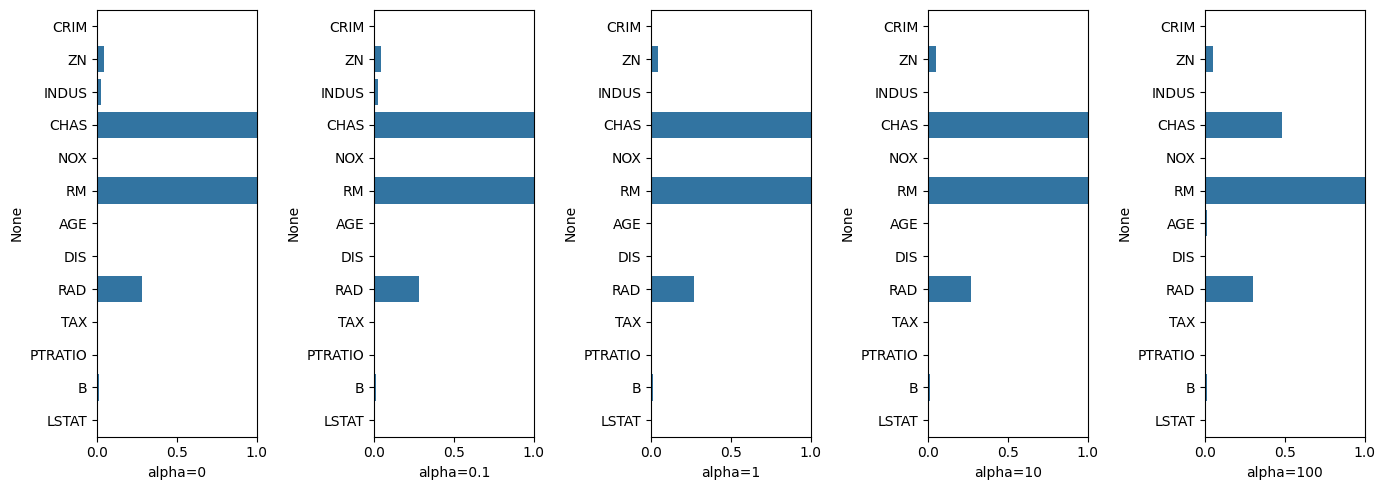

In [33]:
fig, axs = plt.subplots(figsize=(14,5), ncols=len(alphas))
for i, col in enumerate(coef_df.columns):
    axs[i].set_xlim()
    sns.barplot(data=coef_df, x=col, y=coef_df.index, ax=axs[i])
plt.tight_layout()
plt.show()

In [34]:
coef_df.min().min(), coef_df.max().max()

(np.float64(-14.579007503277372), np.float64(3.79511924129442))

#### 각 alpha에 따른 Ridge 모델의 회귀 계수 값 시각화

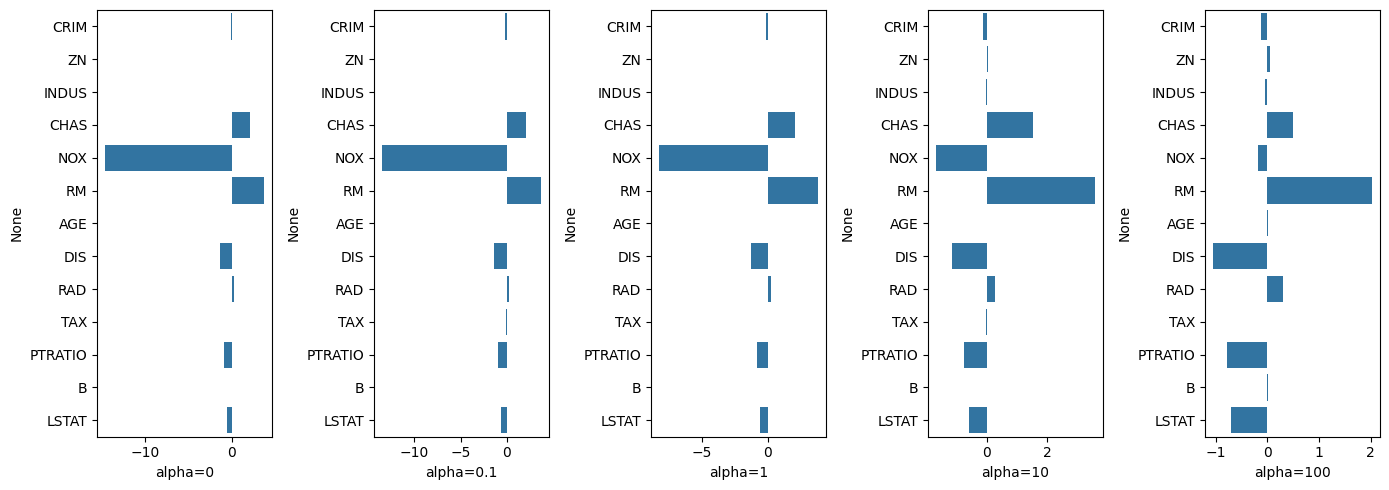

In [35]:
xmin, xmax = np.floor(coef_df.min().min()), np.round(coef_df.max().max())
coef_df
fig, axs = plt.subplots(figsize=(14,5), ncols=len(alphas))
for i, col in enumerate(coef_df.columns):
    sns.barplot(data=coef_df, x=col, y=coef_df.index, ax=axs[i])
plt.tight_layout()
plt.show()

**alpha 값에 따른 컬럼별 회귀계수 출력**

In [62]:
def get_linear_regr_model(model_name, alphas, X, y, feature_names):
    coef_df = pd.DataFrame(index=feature_names)
    for alpha in alphas:
        if model_name == 'Ridge':
            model = Ridge(alpha=alpha)
        elif model_name == 'Lasso':
            model = Lasso(alpha=alpha)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha=alpha, l1_ratio=0.7)
        print(f'## {model}')
        reg_cv_modeling(model, X, y)
        print('------------------\n')
        model.fit(X,y)
        coef_df[f'alpha={alpha}'] = model.coef_
    return coef_df

In [54]:
coef_ridge = get_linear_regr_model('Ridge', [5,10,20], X_train, y_train, feature_names=X.columns)

## Ridge(alpha=5)
Ridge(alpha=5):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
------------------

## Ridge(alpha=10)
Ridge(alpha=10):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
------------------

## Ridge(alpha=20)
Ridge(alpha=20):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
------------------



### 규제가 있는 회귀모델 적용 함수 get_linear_reg_eval() 작성
- 매개변수로 규제회귀 Ridge, Lasso, ElasticNet을 지정하여 해당 규제 모델을 학습하고 예측성능 출력

In [49]:
def coeffs_plot(coef_df, sort=False, figsize=(14,5)):
    xmin, xmax = np.floor(coef_df.min().min()), np.round(coef_df.max().max())
    fig, axs = plt.subplots(figsize=(14,5), ncols=coef_df.shape[1])
    for i, col in enumerate(coef_df.columns):
        axs[i].set_xlim(xmin-1, xmax+1)
        if sort:
            data = coef_df[col].sort_values(ascending=False)
        else:
            dats = coef_df[col]
        sns.barplot(x=data, y=data.index, ax=axs[i])
    plt.tight_layout()
    plt.show()

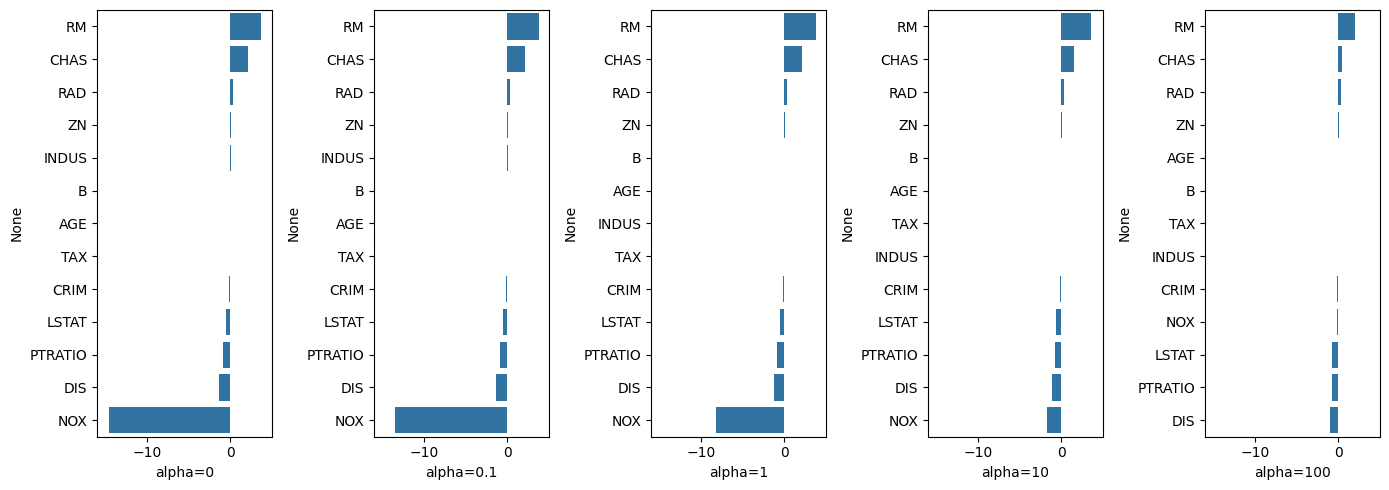

In [59]:
coeffs_plot(coef_df, figsize=(16,5), sort=True)

## 2. 라쏘 회귀모델

### Lasso 회귀 모델 정의 및 모델 평가
- cross_val_score()
- 라쏘 모델의 alpha값 변경

#### get_linear_reg_eval()함수를 사용하여 라쏘모델의 성능 평가

: alpha값을 0.07, 0.1, 0.5, 1, 3으로 지정한 경우 

In [39]:
alphas = [0.07, 0.1, 0.5, 1, 3]
get_linear_regr_model('Lasso',alphas, X_train, y_train, feature_names=X.columns)

Lasso(alpha=0.07):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
Lasso(alpha=0.1):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
Lasso(alpha=0.5):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
Lasso(alpha=1):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
Lasso(alpha=3):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436


,alpha0.07,alpha0.1,alpha0.5,alpha1,alpha3
CRIM,-0.122591,-0.121689,-0.101697,-0.075949,-0.000691
ZN,0.045839,0.046057,0.045570,0.044160,0.028695
INDUS,-0.023889,-0.018542,-0.000000,-0.000000,-0.000000
CHAS,1.035727,0.575235,0.000000,0.000000,0.000000
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
RM,3.753668,3.663300,2.322239,0.603093,0.000000
AGE,-0.002269,-0.000495,0.014242,0.033312,0.049919
DIS,-1.096460,-1.081537,-0.865136,-0.599245,-0.000000
RAD,0.258174,0.260674,0.255698,0.240610,0.004245
TAX,-0.013409,-0.013678,-0.014028,-0.013595,-0.005837


**alpha값에 따른 피처별 회귀 계수**

#### 각 alpha에 따른 Lasso 회귀 계수 값을 시각화

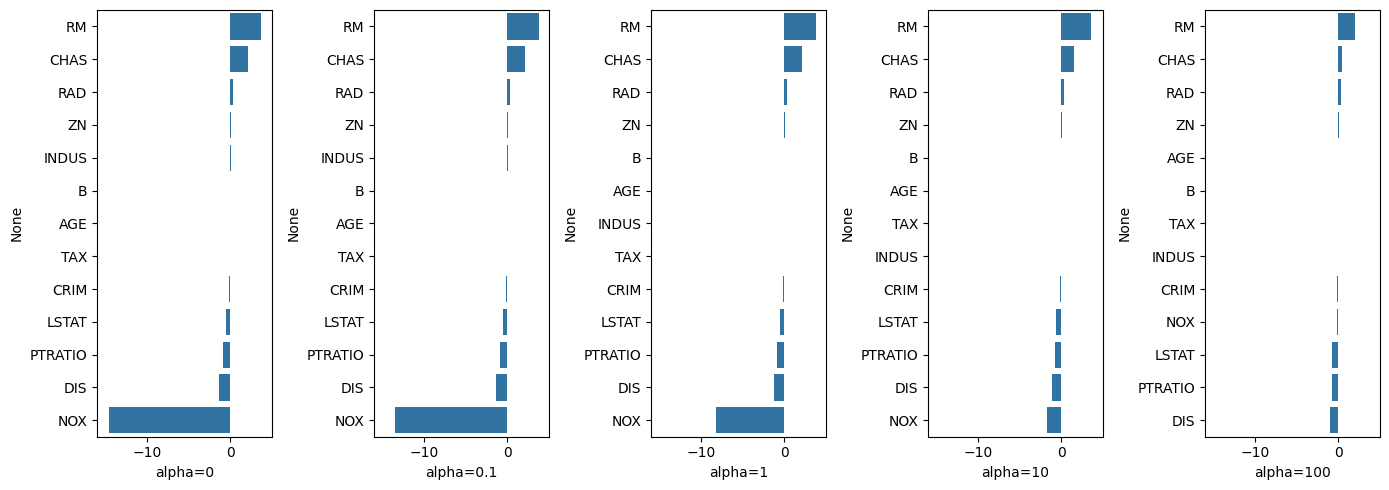

In [60]:
coeffs_plot(coef_df, figsize=(16,5), sort=True)

## 3. 엘라스틱넷 회귀 모델

#### 엘라스틱넷에 사용될 alpha값을 변화시키면서 성능평가

In [64]:
alphas = [0.07, 0.1, 0.5, 1, 3]
coef_elastic = get_linear_regr_model('Lasso',alphas, X_train, y_train, feature_names=X.columns)

## Lasso(alpha=0.07)
Lasso(alpha=0.07):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
------------------

## Lasso(alpha=0.1)
Lasso(alpha=0.1):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
------------------

## Lasso(alpha=0.5)
Lasso(alpha=0.5):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
------------------

## Lasso(alpha=1)
Lasso(alpha=1):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
------------------

## Lasso(alpha=3)
Lasso(alpha=3):5-fold CV
Negative MSE:[-16.615 -18.422 -20.934 -31.636 -31.923]
RMSEs: [4. 4. 5. 6. 6.], Average RMSE: 4.8436
------------------



#### alpha값에 따른 엘라스틱넷 회귀계수

#### l1_ratio=0.7로 고정하고, alpha에 따른 ElasticNet 회귀 계수 값을 시각화

-------------------------------------------------